In [1]:
#env-scgpt
import os
import sys
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys
import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/faiss/loader.py:28: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numpy.__version__) >= "1.19":
/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.vers

In [2]:
model_dir = Path("/data2/lanxiang/embryo_benchmark/scGPT/scGPT_human")
adata = sc.read_h5ad('/data2/lanxiang/embryo_benchmark/25.1.13_update/human_reanno_20250108.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 33406 × 60421
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation', 'final_anno', 'final_lineage'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'dendrogram_lineage', 'dendrogram_reanno', 'final_anno_colors', 'final_lineage_colors', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_col

In [4]:
Weatherbee = sc.read_h5ad('/data2/lanxiang/embryo_benchmark/9.27labeltransfer_data/corrected_processed_Weatherbee.h5ad')

In [5]:
Weatherbee

AnnData object with n_obs × n_vars = 5901 × 31531
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample_type', 'scmap_nakamura', 'scmapCELL_Yang', 'scmap_ma', 'scmap_Tyser', 'scmapCELL_Mole', 'cell_assignment', 'course_cell_assignment', 'stage', 'species', 'embryo', 'platform', 'doublet', 'doublet_score'
    var: 'features', 'n_cells'

In [6]:
Weatherbee.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample_type,scmap_nakamura,scmapCELL_Yang,scmap_ma,scmap_Tyser,scmapCELL_Mole,cell_assignment,course_cell_assignment,stage,species,embryo,platform,doublet,doublet_score
AAACAGCCAATATACC-1_1,Weatherbee,7994.0,3257,4.953715,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Hypoblast,AM-3,AME,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,1.516193e-05
AAACAGCCACTAAGCC-1_1,Weatherbee,8411.0,3593,4.541672,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Cytotrophoblasts,AM-3,AME,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,3.050282e-04
AAACATGCAGTATGTT-1_1,Weatherbee,7937.0,3497,3.187602,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,unassigned,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,9.171038e-07
AAACCAACAATAACCT-1_1,Weatherbee,10750.0,4132,2.483721,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,2.359281e-08
AAACCGAAGGCTAGAA-1_1,Weatherbee,10730.0,4098,3.122088,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,2.735409e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGAGTCATCCGTAA-1,Weatherbee,29746.0,6569,10.925839,double_structure_day4,PostL-EPI,unassigned,postL-EPI,Epiblast,Epiblast,L-EPI,L-EPI,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,3.586937e-04
TTTGGTAAGTTACTTC-1,Weatherbee,44527.0,8383,8.978822,NA,NA,NA,NA,NA,NA,NA,NA,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,4.157939e+00
TTTGTCTAGCATGAAG-1,Weatherbee,9015.0,3987,3.982252,double_structure_day4,PostL-EPI,unassigned,L-AM1,Epiblast,unassigned,AM-1,AME,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,4.369414e-01
TTTGTGAAGTTAACCA-1,Weatherbee,24582.0,6431,4.653812,double_structure_day4,EXMC,extraembryonic mesenchyme,L-Gast2,unassigned,unassigned,MESO-2,Meso,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,6.811725e-01


In [7]:
adata_hvg = adata[:, adata.var.highly_variable].copy()

In [8]:
adata_hvg

AnnData object with n_obs × n_vars = 33406 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation', 'final_anno', 'final_lineage'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'dendrogram_lineage', 'dendrogram_reanno', 'final_anno_colors', 'final_lineage_colors', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_colo

In [9]:
print(adata_hvg.X)

  (0, 0)	0.5896574616062754
  (0, 1)	0.0855016865466988
  (0, 3)	0.0855016865466988
  (0, 5)	0.5896574616062754
  (0, 7)	0.3053158743576146
  (0, 10)	0.0855016865466988
  (0, 11)	0.16426518125366685
  (0, 27)	0.0855016865466988
  (0, 33)	0.16426518125366685
  (0, 38)	1.17297271685056
  (0, 40)	0.3053158743576146
  (0, 41)	0.0855016865466988
  (0, 47)	0.0855016865466988
  (0, 48)	0.8871561621240867
  (0, 54)	0.0855016865466988
  (0, 58)	0.3053158743576146
  (0, 62)	0.0855016865466988
  (0, 63)	0.6379695013722114
  (0, 64)	0.0855016865466988
  (0, 73)	0.0855016865466988
  (0, 75)	0.6379695013722114
  (0, 76)	0.9581008480317472
  (0, 77)	0.16426518125366685
  (0, 78)	0.0855016865466988
  (0, 79)	0.5896574616062754
  :	:
  (33405, 1682)	1.234323601549568
  (33405, 1695)	0.7966179702751798
  (33405, 1700)	4.237138145237701
  (33405, 1703)	0.7966179702751798
  (33405, 1704)	1.5377443379944717
  (33405, 1714)	0.7966179702751798
  (33405, 1729)	0.7966179702751798
  (33405, 1730)	1.234323601549

In [10]:
print(Weatherbee.X)

  (0, 25)	1.0
  (0, 36)	1.0
  (0, 40)	1.0
  (0, 53)	1.0
  (0, 54)	1.0
  (0, 75)	1.0
  (0, 77)	2.0
  (0, 128)	1.0
  (0, 145)	8.0
  (0, 164)	1.0
  (0, 168)	1.0
  (0, 175)	1.0
  (0, 181)	1.0
  (0, 184)	2.0
  (0, 188)	9.0
  (0, 191)	1.0
  (0, 211)	1.0
  (0, 215)	1.0
  (0, 216)	1.0
  (0, 223)	1.0
  (0, 234)	1.0
  (0, 249)	1.0
  (0, 263)	1.0
  (0, 287)	1.0
  (0, 320)	1.0
  :	:
  (5900, 31431)	1.0
  (5900, 31438)	2.0
  (5900, 31444)	7.0
  (5900, 31446)	1.0
  (5900, 31447)	37.0
  (5900, 31454)	2.0
  (5900, 31456)	2.0
  (5900, 31457)	1.0
  (5900, 31459)	1.0
  (5900, 31464)	5.0
  (5900, 31469)	2.0
  (5900, 31472)	1.0
  (5900, 31505)	91.0
  (5900, 31506)	52.0
  (5900, 31507)	461.0
  (5900, 31508)	429.0
  (5900, 31509)	18.0
  (5900, 31510)	348.0
  (5900, 31511)	629.0
  (5900, 31512)	46.0
  (5900, 31513)	7.0
  (5900, 31514)	84.0
  (5900, 31515)	37.0
  (5900, 31516)	5.0
  (5900, 31517)	230.0


In [11]:
sc.settings.seed = 42
Weatherbee.layers["counts"] =Weatherbee.X.copy()
sc.pp.normalize_total(Weatherbee, target_sum=1e4)
sc.pp.log1p(Weatherbee)
Weatherbee.layers["logcounts"] = Weatherbee.X.copy()
sc.pp.highly_variable_genes(Weatherbee, n_top_genes=2000, flavor="cell_ranger", batch_key="orig.ident")
sc.tl.pca(Weatherbee, n_comps=30, use_highly_variable=True)

In [12]:
Weatherbee_hvg = Weatherbee[:, Weatherbee.var.highly_variable].copy()

In [13]:
Weatherbee_hvg

AnnData object with n_obs × n_vars = 5901 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample_type', 'scmap_nakamura', 'scmapCELL_Yang', 'scmap_ma', 'scmap_Tyser', 'scmapCELL_Mole', 'cell_assignment', 'course_cell_assignment', 'stage', 'species', 'embryo', 'platform', 'doublet', 'doublet_score'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'logcounts'

# final_anno

In [14]:
gene_col = "features"
cell_type_key = "final_anno"

In [15]:
original_adata_hvg = adata_hvg.copy()
original_Weatherbee_hvg=Weatherbee_hvg.copy()

In [16]:
ref_embed_adata = scg.tasks.embed_data(
    adata_hvg,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)


scGPT - INFO - match 1823/2000 genes in vocabulary of size 60697.


/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 522/522 [00:44<00:00, 11.74it/s]


In [17]:
test_embed_adata = scg.tasks.embed_data(
    Weatherbee_hvg,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1715/2000 genes in vocabulary of size 60697.


/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 93/93 [00:15<00:00,  6.05it/s]


In [18]:
ref_embed_adata

AnnData object with n_obs × n_vars = 33406 × 1823
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation', 'final_anno', 'final_lineage'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'id_in_vocab'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'dendrogram_lineage', 'dendrogram_reanno', 'final_anno_colors', 'final_lineage_colors', 'harmo.anno_colors', 'hvg', 'leiden',

In [19]:
test_embed_adata

AnnData object with n_obs × n_vars = 5901 × 1715
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample_type', 'scmap_nakamura', 'scmapCELL_Yang', 'scmap_ma', 'scmap_Tyser', 'scmapCELL_Mole', 'cell_assignment', 'course_cell_assignment', 'stage', 'species', 'embryo', 'platform', 'doublet', 'doublet_score'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'id_in_vocab'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_scGPT'
    varm: 'PCs'
    layers: 'counts', 'logcounts'

In [20]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype('category')
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [21]:
adata_concat

AnnData object with n_obs × n_vars = 39307 × 789
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample_type', 'scmap_nakamura', 'scmapCELL_Yang', 'scmap_ma', 'scmap_Tyser', 'scmapCELL_Mole', 'cell_assignment', 'course_cell_assignment', 'stage', 'species', 'embryo', 'platform', 'doublet', 'doublet_score', 'sample', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation', 'final_anno', 'final_lineage', 'dataset', 'is_ref'
    var: 'features', 'highly_variable', 'id_in_vocab', 'n_cells-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'n_cells-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable_nbatches-1', 'highly_variable_intersection-1'
    ob

In [22]:
adata_concat.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample_type,scmap_nakamura,scmapCELL_Yang,scmap_ma,scmap_Tyser,scmapCELL_Mole,...,leiden_3,leiden_4,reanno,lineage,unicorns,combined_annotation,final_anno,final_lineage,dataset,is_ref
AAACAGCCAATATACC-1_1-0,Weatherbee,7994.0,3257,4.953715,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,NaN,0,Query
AAACAGCCACTAAGCC-1_1-0,Weatherbee,8411.0,3593,4.541672,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Cytotrophoblasts,...,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,NaN,0,Query
AAACATGCAGTATGTT-1_1-0,Weatherbee,7937.0,3497,3.187602,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,unassigned,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,NaN,0,Query
AAACCAACAATAACCT-1_1-0,Weatherbee,10750.0,4132,2.483721,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,NaN,0,Query
AAACCGAAGGCTAGAA-1_1-0,Weatherbee,10730.0,4098,3.122088,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,NaN,0,Query
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAATCTGA-1,zhou,7297.0,2026,12.210497,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,STBs_1,TE_TrB,1,Reference
GCCAAGAC-1,zhou,7962.0,2019,0.879176,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,CTBs_2,TE_TrB,1,Reference
GTCGTAGA-1,zhou,9702.0,2740,4.648526,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,CTBs_2,TE_TrB,1,Reference
TATCAGCA-1,zhou,10857.0,2771,3.232937,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,CTBs_2,TE_TrB,1,Reference


/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


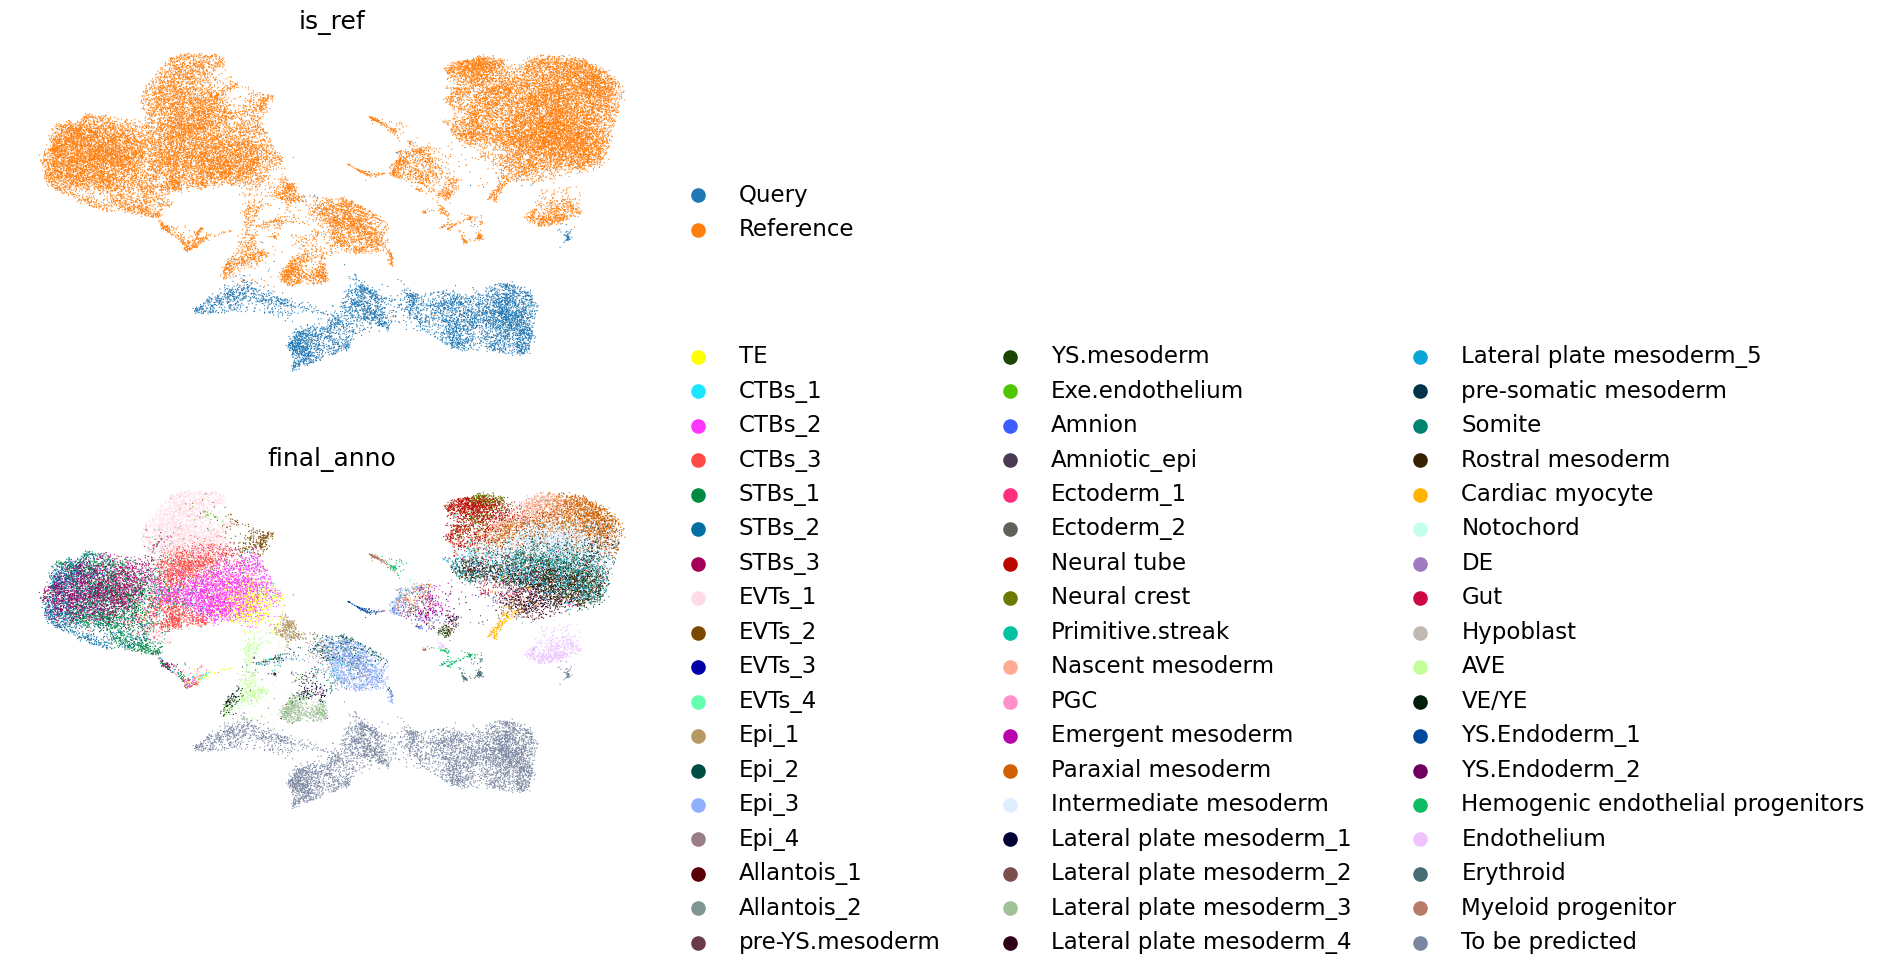

In [23]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1)

In [24]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])

In [25]:
preds

['Ectoderm_1',
 'Lateral plate mesoderm_5',
 'Rostral mesoderm',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Ectoderm_1',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Rostral mesoderm',
 'Intermediate mesoderm',
 'Somite',
 'Lateral plate mesoderm_1',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'pre-somatic mesoderm',
 'AVE',
 'Lateral plate mesoderm_3',
 'Endothelium',
 'Lateral plate mesoderm_3',
 'Epi_3',
 'Somite',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Ectoderm_1',
 'Ectoderm_1',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'VE/YE',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_4',
 'Allantois_1',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_3',
 'Ectoderm_1',
 'Lateral plate mesoderm_3',
 'Lateral plate mesoderm_

In [26]:
len(preds)

5901

In [27]:
adata_concat

AnnData object with n_obs × n_vars = 39307 × 789
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample_type', 'scmap_nakamura', 'scmapCELL_Yang', 'scmap_ma', 'scmap_Tyser', 'scmapCELL_Mole', 'cell_assignment', 'course_cell_assignment', 'stage', 'species', 'embryo', 'platform', 'doublet', 'doublet_score', 'sample', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation', 'final_anno', 'final_lineage', 'dataset', 'is_ref'
    var: 'features', 'highly_variable', 'id_in_vocab', 'n_cells-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'n_cells-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable_nbatches-1', 'highly_variable_intersection-1'
    un

In [28]:
adata_concat.obs["orig.ident"].value_counts()

orig.ident
zeng          13680
Ai             8611
Weatherbee     5901
mole           5205
zhou           4224
tyser          1172
xiang           514
Name: count, dtype: int64

In [29]:
Weatherbee.obs["scgpt_final_anno_pre"] = preds

In [30]:
Weatherbee.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample_type,scmap_nakamura,scmapCELL_Yang,scmap_ma,scmap_Tyser,scmapCELL_Mole,cell_assignment,course_cell_assignment,stage,species,embryo,platform,doublet,doublet_score,scgpt_final_anno_pre
AAACAGCCAATATACC-1_1,Weatherbee,7994.0,3257,4.953715,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Hypoblast,AM-3,AME,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,1.516193e-05,Ectoderm_1
AAACAGCCACTAAGCC-1_1,Weatherbee,8411.0,3593,4.541672,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Cytotrophoblasts,AM-3,AME,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,3.050282e-04,Lateral plate mesoderm_5
AAACATGCAGTATGTT-1_1,Weatherbee,7937.0,3497,3.187602,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,unassigned,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,9.171038e-07,Rostral mesoderm
AAACCAACAATAACCT-1_1,Weatherbee,10750.0,4132,2.483721,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,2.359281e-08,Lateral plate mesoderm_3
AAACCGAAGGCTAGAA-1_1,Weatherbee,10730.0,4098,3.122088,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,2.735409e-09,Lateral plate mesoderm_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGAGTCATCCGTAA-1,Weatherbee,29746.0,6569,10.925839,double_structure_day4,PostL-EPI,unassigned,postL-EPI,Epiblast,Epiblast,L-EPI,L-EPI,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,3.586937e-04,Epi_3
TTTGGTAAGTTACTTC-1,Weatherbee,44527.0,8383,8.978822,NA,NA,NA,NA,NA,NA,NA,NA,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,4.157939e+00,Neural tube
TTTGTCTAGCATGAAG-1,Weatherbee,9015.0,3987,3.982252,double_structure_day4,PostL-EPI,unassigned,L-AM1,Epiblast,unassigned,AM-1,AME,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,4.369414e-01,Epi_3
TTTGTGAAGTTAACCA-1,Weatherbee,24582.0,6431,4.653812,double_structure_day4,EXMC,extraembryonic mesenchyme,L-Gast2,unassigned,unassigned,MESO-2,Meso,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,6.811725e-01,Lateral plate mesoderm_3


# final_lineage

In [31]:
gene_col = "features"
cell_type_key = "final_lineage"

In [32]:
adata_hvg = original_adata_hvg.copy()
Weatherbee_hvg = original_Weatherbee_hvg.copy()

In [33]:
ref_embed_adata = scg.tasks.embed_data(
    adata_hvg,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)


scGPT - INFO - match 1823/2000 genes in vocabulary of size 60697.


/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 522/522 [00:40<00:00, 12.99it/s]


In [34]:
test_embed_adata = scg.tasks.embed_data(
    Weatherbee_hvg,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1715/2000 genes in vocabulary of size 60697.


/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 93/93 [00:16<00:00,  5.49it/s]


In [35]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype('category')
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [36]:
adata_concat

AnnData object with n_obs × n_vars = 39307 × 789
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample_type', 'scmap_nakamura', 'scmapCELL_Yang', 'scmap_ma', 'scmap_Tyser', 'scmapCELL_Mole', 'cell_assignment', 'course_cell_assignment', 'stage', 'species', 'embryo', 'platform', 'doublet', 'doublet_score', 'sample', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation', 'final_anno', 'final_lineage', 'dataset', 'is_ref'
    var: 'features', 'highly_variable', 'id_in_vocab', 'n_cells-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'n_cells-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable_nbatches-1', 'highly_variable_intersection-1'
    ob

In [37]:
adata_concat.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample_type,scmap_nakamura,scmapCELL_Yang,scmap_ma,scmap_Tyser,scmapCELL_Mole,...,leiden_3,leiden_4,reanno,lineage,unicorns,combined_annotation,final_anno,final_lineage,dataset,is_ref
AAACAGCCAATATACC-1_1-0,Weatherbee,7994.0,3257,4.953715,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,0,Query
AAACAGCCACTAAGCC-1_1-0,Weatherbee,8411.0,3593,4.541672,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Cytotrophoblasts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,0,Query
AAACATGCAGTATGTT-1_1-0,Weatherbee,7937.0,3497,3.187602,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,unassigned,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,0,Query
AAACCAACAATAACCT-1_1-0,Weatherbee,10750.0,4132,2.483721,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,0,Query
AAACCGAAGGCTAGAA-1_1-0,Weatherbee,10730.0,4098,3.122088,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To be predicted,0,Query
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAATCTGA-1,zhou,7297.0,2026,12.210497,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,STBs_1,TE_TrB,1,Reference
GCCAAGAC-1,zhou,7962.0,2019,0.879176,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,CTBs_2,TE_TrB,1,Reference
GTCGTAGA-1,zhou,9702.0,2740,4.648526,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,CTBs_2,TE_TrB,1,Reference
TATCAGCA-1,zhou,10857.0,2771,3.232937,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4.0,nan,CTBs,TE_TrB,non-unicorn,CTBs_zhou,CTBs_2,TE_TrB,1,Reference


/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data2/lanxiang/conda/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


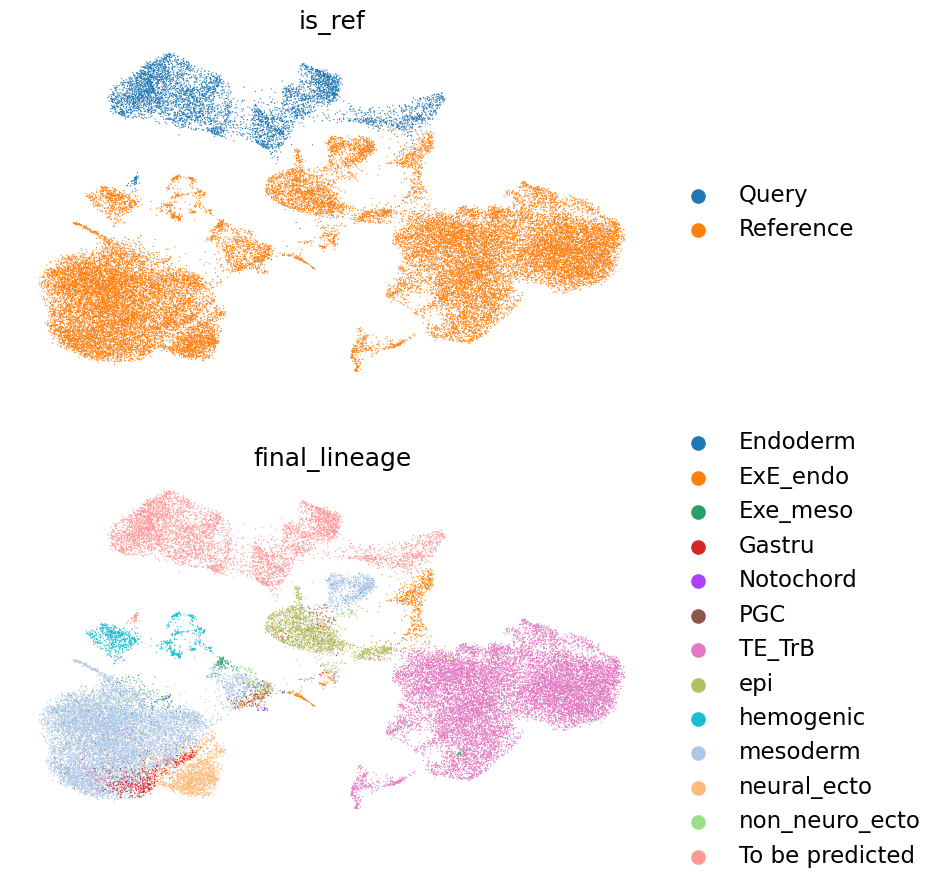

In [38]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1)

In [39]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])

In [40]:
preds

['mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'non_neuro_ecto',
 'mesoderm',
 'mesoderm',
 'non_neuro_ecto',
 'non_neuro_ecto',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'ExE_endo',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'non_neuro_ecto',
 'non_neuro_ecto',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'non_neuro_ecto',
 'mesoderm',
 'mesoderm',
 'ExE_endo',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'ExE_endo',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'non_neuro_ecto',
 'ExE_endo',
 'mesoderm',
 'mesoderm',
 'ExE_endo',
 'mesoderm',
 'mesoderm',
 'mesoderm',
 'hemogenic',
 'mesoderm',
 'mesoderm',
 'epi',
 'mesoderm',
 'epi',
 'non_neuro_ecto',
 'mesoderm',
 'mesoderm',

In [41]:
Weatherbee.obs["scgpt_final_lineage_pre"] = preds

In [42]:
Weatherbee.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample_type,scmap_nakamura,scmapCELL_Yang,scmap_ma,scmap_Tyser,scmapCELL_Mole,cell_assignment,course_cell_assignment,stage,species,embryo,platform,doublet,doublet_score,scgpt_final_anno_pre,scgpt_final_lineage_pre
AAACAGCCAATATACC-1_1,Weatherbee,7994.0,3257,4.953715,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Hypoblast,AM-3,AME,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,1.516193e-05,Ectoderm_1,mesoderm
AAACAGCCACTAAGCC-1_1,Weatherbee,8411.0,3593,4.541672,double_structure_day8,Post-paTE,unassigned,L-AM2,Amnion,Cytotrophoblasts,AM-3,AME,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,3.050282e-04,Lateral plate mesoderm_5,mesoderm
AAACATGCAGTATGTT-1_1,Weatherbee,7937.0,3497,3.187602,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,unassigned,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,9.171038e-07,Rostral mesoderm,mesoderm
AAACCAACAATAACCT-1_1,Weatherbee,10750.0,4132,2.483721,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,2.359281e-08,Lateral plate mesoderm_3,mesoderm
AAACCGAAGGCTAGAA-1_1,Weatherbee,10730.0,4098,3.122088,double_structure_day8,EXMC,extraembryonic mesenchyme,EXMC,YS Mesoderm,Hypoblast,EXMC,EXMC,D8,Homo sapiens,Embryo Model,10x-Genomics,0.0,2.735409e-09,Lateral plate mesoderm_3,mesoderm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGAGTCATCCGTAA-1,Weatherbee,29746.0,6569,10.925839,double_structure_day4,PostL-EPI,unassigned,postL-EPI,Epiblast,Epiblast,L-EPI,L-EPI,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,3.586937e-04,Epi_3,epi
TTTGGTAAGTTACTTC-1,Weatherbee,44527.0,8383,8.978822,NA,NA,NA,NA,NA,NA,NA,NA,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,4.157939e+00,Neural tube,neural_ecto
TTTGTCTAGCATGAAG-1,Weatherbee,9015.0,3987,3.982252,double_structure_day4,PostL-EPI,unassigned,L-AM1,Epiblast,unassigned,AM-1,AME,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,4.369414e-01,Epi_3,epi
TTTGTGAAGTTAACCA-1,Weatherbee,24582.0,6431,4.653812,double_structure_day4,EXMC,extraembryonic mesenchyme,L-Gast2,unassigned,unassigned,MESO-2,Meso,D4,Homo sapiens,Embryo Model,10x-Genomics,0.0,6.811725e-01,Lateral plate mesoderm_3,mesoderm


In [43]:
Weatherbee.obs.to_csv("/data2/lanxiang/embryo_benchmark/25.1.13_update/human_Weatherbee_scgpt.csv", index=True)

In [44]:
Weatherbee.write_h5ad("/data2/lanxiang/embryo_benchmark/25.1.13_update/human_Weatherbee_scgpt.h5ad")

In [46]:
import scgpt as scg
print(scg.__version__)


0.2.1
